In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


IMPORT DATA

In [ ]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [ ]:
x_train, y_train = load_mnist('/content/drive/MyDrive/UAS_DEEP_LEARNING_NOMOR_2', kind='train')

Melihat contoh image

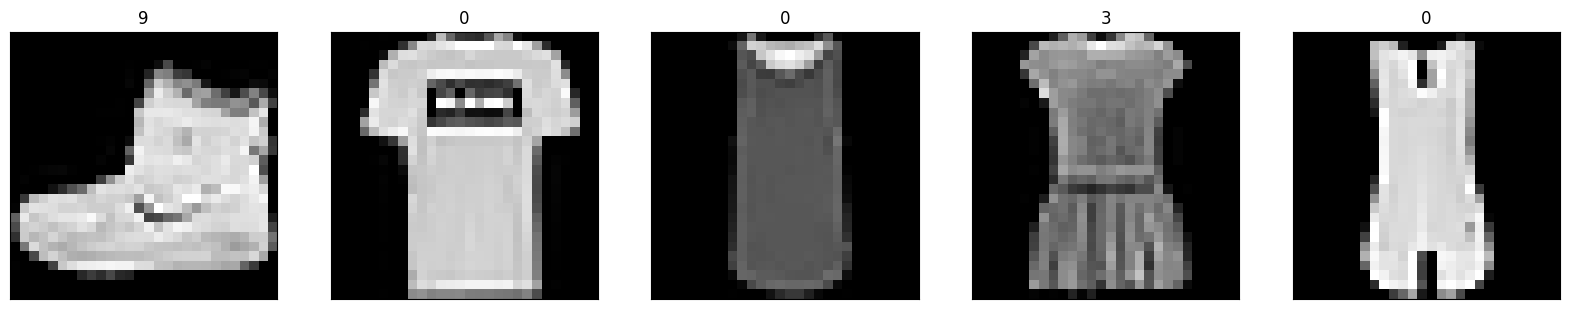

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"{y_train[i]}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


Filter Data menjadi 2 class saja sesuai dengan class yang sudah dibagi berdasarkan NIM dan Gender (Coat and Sandal)

In [ ]:
train_filter = np.isin(y_train, [4, 5])
x_train_filtered = x_train[train_filter]
y_train_filtered = y_train[train_filter]

print(np.unique(y_train_filtered))

[4 5]


Melihat contoh image yang sudah di filter (coat dan sandal)

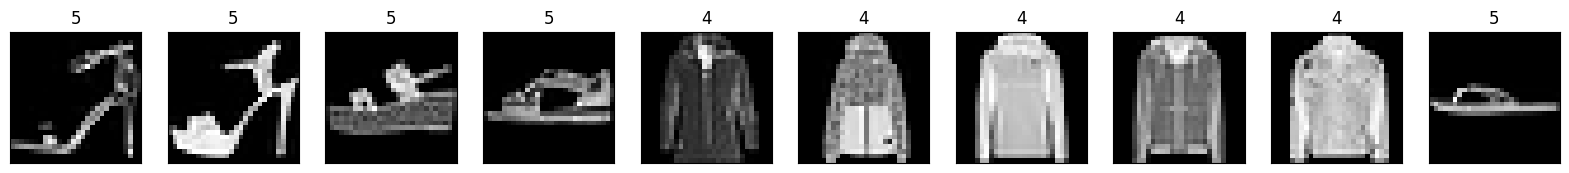

In [ ]:
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(x_train_filtered[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"{y_train_filtered[i]}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Normalize image

In [ ]:
x_train_filtered = x_train_filtered.reshape(-1, 28, 28, 1).astype('float32') / 255.0

split image menjadi 80% train, 10% validation dan 10% test

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_sisa, y_train, y_sisa = train_test_split(x_train_filtered, y_train_filtered, test_size = 0.2, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_sisa, y_sisa, test_size = 0.5, random_state = 42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(9600, 28, 28, 1) (9600,)
(1200, 28, 28, 1) (1200,)
(1200, 28, 28, 1) (1200,)


Untuk model, input untuk model adalah image dengan size 28 kali 28 sesuai dengan size image fashion mnist nya. Lalu ada 2 bagian, encoder dan decoder, untuk encoder ada 2D convolution dengan 32 filter dengan size 3x3 dan menggunakan activation relu dan juga padding same. Lalu maxpooling dilakukan untuk mengurangi dimension menjadi setengahnya. Lalu di flatten menjadi 1D array dan ada Fully connected layer dengan unit sebesar 128 dan activation menggunakan relu. Untuk decoder ada fully connected layer dan image di reshape menjadi 14 kali 14 x 32, lalu image di upsampling sebesar 2 kali lalu ada layer lagi dengan 32 filter dan sizenya 3x3 dengan relu activation. Lalu layer terakhir untuk output value antara 0 atau 1 menggunakan activation sigmoid. Lalu define model autoencoder dengan input image sebagai input dan decoder sebagai output. lalu model di compile menggunakan optimizer adam dan loss function binary crossentropy karena output binary.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, Input
from tensorflow.keras.models import Model
from skimage.metrics import structural_similarity as ssim

input_image = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(input_image)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Flatten()(x)
encoded = Dense(128, activation = 'relu')(x)

x = Dense(14 * 14 * 32, activation = 'relu')(encoded)
x = Reshape((14, 14, 32))(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(x)
decoded = Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(x)

autoencoder = Model(input_image, decoded)
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 128)               802944    
                                                                 
 dense_1 (Dense)             (None, 6272)              809088    
                                                             

model di train menggunakan 50 epoch dan 256 batch size dan menggunakan validation data

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs = 50, batch_size = 256, shuffle = True, validation_data = (x_val, x_val))

Epoch 1/50
38/38 [==============================] - 38s 920ms/step - loss: 0.4254 - val_loss: 0.3326
Epoch 2/50
38/38 [==============================] - 33s 878ms/step - loss: 0.3079 - val_loss: 0.2942
Epoch 3/50
38/38 [==============================] - 34s 907ms/step - loss: 0.2854 - val_loss: 0.2805
Epoch 4/50
38/38 [==============================] - 34s 889ms/step - loss: 0.2746 - val_loss: 0.2718
Epoch 5/50
38/38 [==============================] - 40s 1s/step - loss: 0.2674 - val_loss: 0.2663
Epoch 6/50
38/38 [==============================] - 35s 911ms/step - loss: 0.2623 - val_loss: 0.2619
Epoch 7/50
38/38 [==============================] - 33s 863ms/step - loss: 0.2592 - val_loss: 0.2595
Epoch 8/50
38/38 [==============================] - 32s 851ms/step - loss: 0.2563 - val_loss: 0.2568
Epoch 9/50
38/38 [==============================] - 32s 839ms/step - loss: 0.2543 - val_loss: 0.2551
Epoch 10/50
38/38 [==============================] - 37s 972ms/step - loss: 0.2526 - val_loss:

hasil dari training loss dan validation loss cukup bagus karena dua2nya menurun dengan stabil

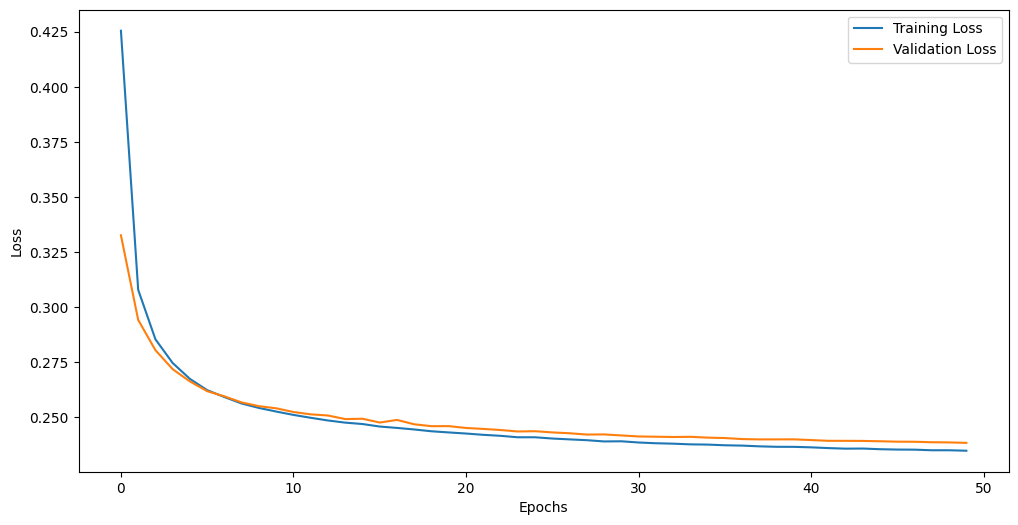

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
final_image = autoencoder.predict(x_test)

38/38 [==============================] - 1s 26ms/step


SSIM yang di dapat cukup bagus dengan nilai 0.8517 dimana semakin dekat dengan 1 semakin bagus karena semakin mirip image asli.

In [ ]:
ssim_values = []
for i in range(len(x_test)):
    ssim_value = ssim(x_test[i].reshape(28, 28), final_image[i].reshape(28, 28), data_range = final_image[i].max() - final_image[i].min())
    ssim_values.append(ssim_value)

mean_ssim = np.mean(ssim_values)
print(f'Mean SSIM: {mean_ssim}')

Mean SSIM: 0.8517423596904221


perbandingan hasil dengan image asli

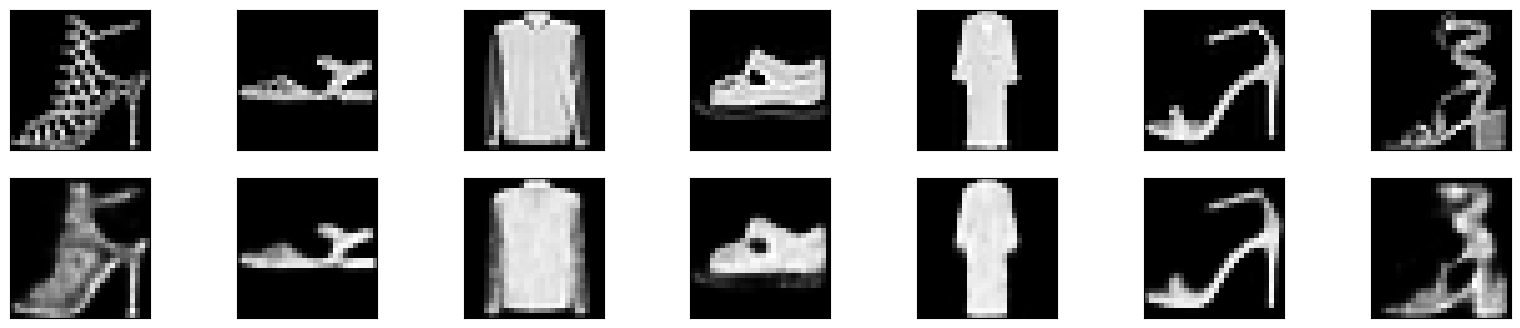

In [ ]:
plt.figure(figsize=(20, 4))
for i in range(7):
    # Display original
    ax = plt.subplot(2, 7, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, 7, i + 1 + 7)
    plt.imshow(final_image[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Mencoba menambahkan layer menjadi 2 layer dengan filter 64 dan activation relu dan padding same.

In [ ]:
# model tuning
y = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(input_image)
y = MaxPooling2D((2, 2), padding = 'same')(y)
y = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(y)
y = MaxPooling2D((2, 2), padding = 'same')(y)
y = Flatten()(y)
encoded_2 = Dense(128, activation = 'relu')(y)

y = Dense(7 * 7 * 64, activation = 'relu')(encoded_2)
y = Reshape((7, 7, 64))(y)
y = UpSampling2D((2, 2))(y)
y = Conv2D(64, (3, 3), activation='relu', padding='same')(y)
y = UpSampling2D((2, 2))(y)
y = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(y)
decoded_2 = Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(y)

autoencoder_tuned = Model(input_image, decoded_2)
autoencoder_tuned.compile(optimizer = 'adam', loss = 'binary_crossentropy')
autoencoder_tuned.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0   

train dengan epoch dan batch size yang sama

In [ ]:
history_2 = autoencoder_tuned.fit(x_train, x_train, epochs = 50, batch_size = 256, shuffle = True, validation_data = (x_val, x_val))

Epoch 1/50
38/38 [==============================] - 80s 2s/step - loss: 0.4108 - val_loss: 0.3250
Epoch 2/50
38/38 [==============================] - 69s 2s/step - loss: 0.3064 - val_loss: 0.2950
Epoch 3/50
38/38 [==============================] - 74s 2s/step - loss: 0.2872 - val_loss: 0.2829
Epoch 4/50
38/38 [==============================] - 71s 2s/step - loss: 0.2777 - val_loss: 0.2797
Epoch 5/50
38/38 [==============================] - 71s 2s/step - loss: 0.2721 - val_loss: 0.2697
Epoch 6/50
38/38 [==============================] - 76s 2s/step - loss: 0.2679 - val_loss: 0.2668
Epoch 7/50
38/38 [==============================] - 75s 2s/step - loss: 0.2642 - val_loss: 0.2668
Epoch 8/50
38/38 [==============================] - 75s 2s/step - loss: 0.2630 - val_loss: 0.2626
Epoch 9/50
38/38 [==============================] - 76s 2s/step - loss: 0.2594 - val_loss: 0.2598
Epoch 10/50
38/38 [==============================] - 71s 2s/step - loss: 0.2578 - val_loss: 0.2608
Epoch 11/50
38/38 [

hasil training loss dan validation loss lebih tidak stabil turunnya.

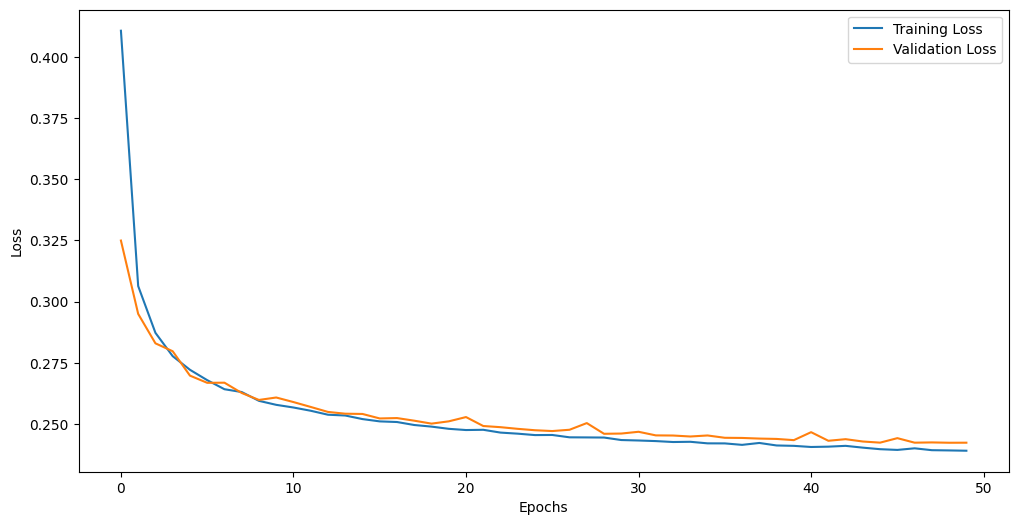

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(history_2.history['loss'], label = 'Training Loss')
plt.plot(history_2.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
final_image_2 = autoencoder_tuned.predict(x_test)

38/38 [==============================] - 2s 50ms/step


SSIM skor lebih rendah sedikit dibanding model base awal.

In [ ]:
ssim_values_2 = []
for i in range(len(x_test)):
    ssim_value_2 = ssim(x_test[i].reshape(28, 28), final_image_2[i].reshape(28, 28), data_range_2 = final_image_2[i].max() - final_image_2[i].min())
    ssim_values_2.append(ssim_value_2)

mean_ssim_2 = np.mean(ssim_values_2)
print(f'Mean SSIM: {mean_ssim_2}')

Mean SSIM: 0.8506177065395164


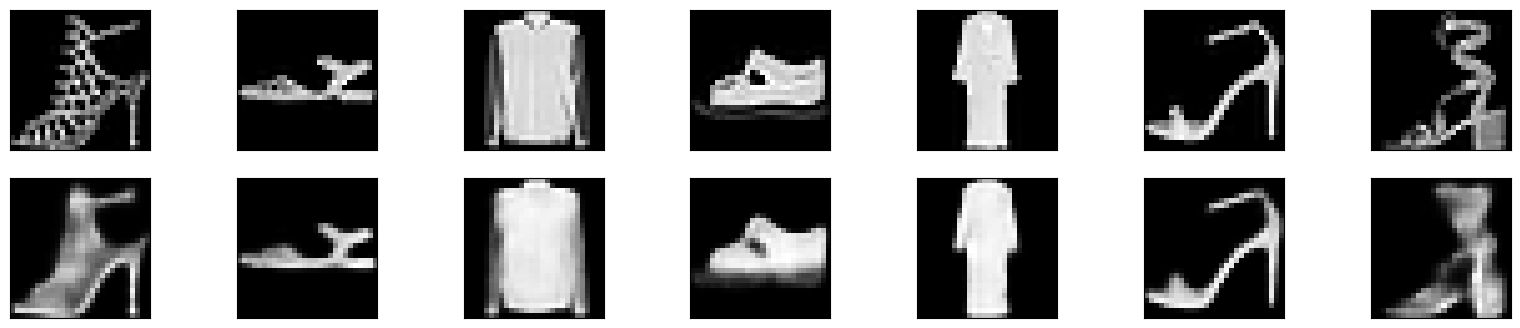

In [ ]:
plt.figure(figsize=(20, 4))
for i in range(7):
    # Display original
    ax = plt.subplot(2, 7, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, 7, i + 1 + 7)
    plt.imshow(final_image_2[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Mencoba mengurangi jumlah filter menjadi 16 dan 32 untuk kedua layer

In [ ]:
# model tuning 2
from keras.optimizers import Adam
z = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(input_image)
z = MaxPooling2D((2, 2), padding = 'same')(z)
z = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(z)
z = MaxPooling2D((2, 2), padding = 'same')(z)
z = Flatten()(z)
encoded_3 = Dense(128, activation = 'relu')(z)

z = Dense(7 * 7 * 64, activation = 'relu')(encoded_3)
z = Reshape((7, 7, 64))(z)
z = UpSampling2D((2, 2))(z)
z = Conv2D(32, (3, 3), activation='relu', padding='same')(z)
z = UpSampling2D((2, 2))(z)
z = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(z)
decoded_3 = Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(z)

autoencoder_tuned_2 = Model(input_image, decoded_3)
autoencoder_tuned_2.compile(optimizer = Adam(lr=0.001), loss = 'binary_crossentropy')
autoencoder_tuned_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 1568)              0   

train dengan epoch dan batch size yang sama

In [ ]:
history_3 = autoencoder_tuned_2.fit(x_train, x_train, epochs = 50, batch_size = 256, shuffle = True, validation_data = (x_val, x_val))

Epoch 1/50
38/38 [==============================] - 34s 849ms/step - loss: 0.4400 - val_loss: 0.3445
Epoch 2/50
38/38 [==============================] - 35s 929ms/step - loss: 0.3205 - val_loss: 0.3043
Epoch 3/50
38/38 [==============================] - 34s 897ms/step - loss: 0.2951 - val_loss: 0.2902
Epoch 4/50
38/38 [==============================] - 32s 857ms/step - loss: 0.2835 - val_loss: 0.2801
Epoch 5/50
38/38 [==============================] - 32s 850ms/step - loss: 0.2766 - val_loss: 0.2745
Epoch 6/50
38/38 [==============================] - 33s 882ms/step - loss: 0.2720 - val_loss: 0.2711
Epoch 7/50
38/38 [==============================] - 38s 1s/step - loss: 0.2686 - val_loss: 0.2678
Epoch 8/50
38/38 [==============================] - 35s 923ms/step - loss: 0.2652 - val_loss: 0.2650
Epoch 9/50
38/38 [==============================] - 34s 896ms/step - loss: 0.2626 - val_loss: 0.2656
Epoch 10/50
38/38 [==============================] - 32s 826ms/step - loss: 0.2614 - val_loss:

hasil training loss dan validation loss masih sama

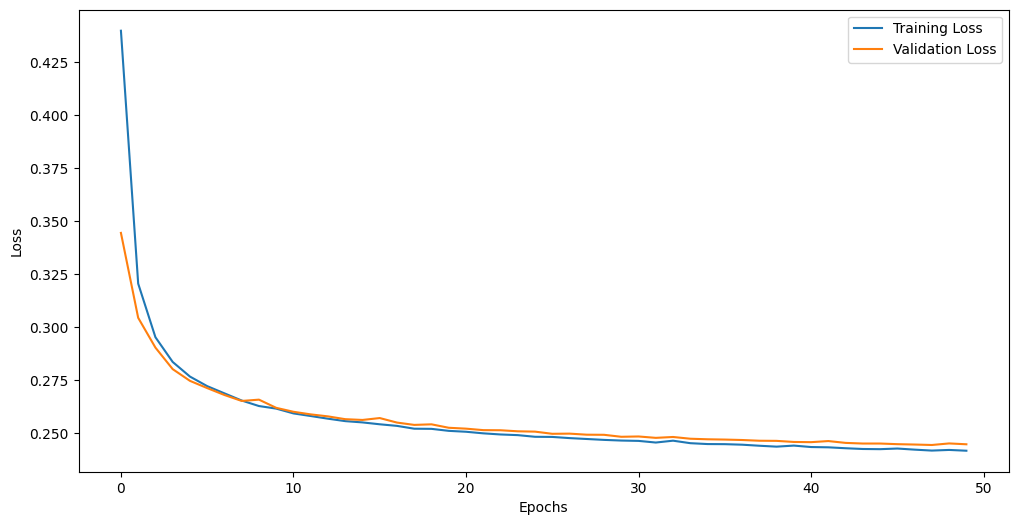

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(history_3.history['loss'], label = 'Training Loss')
plt.plot(history_3.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
final_image_3 = autoencoder_tuned_2.predict(x_test)

38/38 [==============================] - 1s 24ms/step


SSIM skor menurun lagi

In [ ]:
ssim_values_3 = []
for i in range(len(x_test)):
    ssim_value_3 = ssim(x_test[i].reshape(28, 28), final_image_3[i].reshape(28, 28), data_range_3 = final_image_3[i].max() - final_image_3[i].min())
    ssim_values_3.append(ssim_value_3)

mean_ssim_3 = np.mean(ssim_values_3)
print(f'Mean SSIM: {mean_ssim_3}')

Mean SSIM: 0.8423197102841935


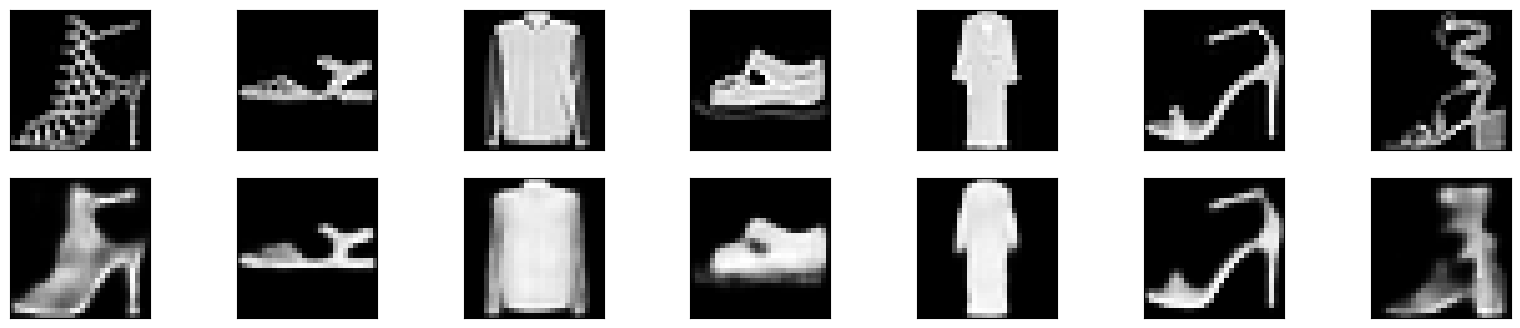

In [ ]:
plt.figure(figsize=(20, 4))
for i in range(7):
    # Display original
    ax = plt.subplot(2, 7, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, 7, i + 1 + 7)
    plt.imshow(final_image_3[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Mencoba model dengan 1 layer saja dengan mengurangi jumlah filter menjadi 16

In [ ]:
#model tune 3
x1 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(input_image)
x1 = MaxPooling2D((2, 2), padding = 'same')(x1)
x1 = Flatten()(x1)
encoded4 = Dense(128, activation = 'relu')(x1)

x1 = Dense(14 * 14 * 32, activation = 'relu')(encoded4)
x1 = Reshape((14, 14, 32))(x1)
x1 = UpSampling2D((2, 2))(x1)
x1 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(x1)
decoded4 = Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(x1)

autoencoder_4 = Model(input_image, decoded4)
autoencoder_4.compile(optimizer = 'adam', loss = 'binary_crossentropy')
autoencoder_4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 3136)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               401536    
                                                                 
 dense_7 (Dense)             (None, 6272)              809088    
                                                           

train dengan epoch dan batch size yang sama

In [ ]:
history_4 = autoencoder_4.fit(x_train, x_train, epochs = 50, batch_size = 256, shuffle = True, validation_data = (x_val, x_val))

Epoch 1/50
38/38 [==============================] - 26s 637ms/step - loss: 0.4663 - val_loss: 0.3410
Epoch 2/50
38/38 [==============================] - 23s 612ms/step - loss: 0.3122 - val_loss: 0.2978
Epoch 3/50
38/38 [==============================] - 22s 589ms/step - loss: 0.2904 - val_loss: 0.2861
Epoch 4/50
38/38 [==============================] - 23s 612ms/step - loss: 0.2801 - val_loss: 0.2766
Epoch 5/50
38/38 [==============================] - 24s 626ms/step - loss: 0.2726 - val_loss: 0.2715
Epoch 6/50
38/38 [==============================] - 24s 634ms/step - loss: 0.2672 - val_loss: 0.2663
Epoch 7/50
38/38 [==============================] - 22s 573ms/step - loss: 0.2634 - val_loss: 0.2633
Epoch 8/50
38/38 [==============================] - 26s 677ms/step - loss: 0.2603 - val_loss: 0.2613
Epoch 9/50
38/38 [==============================] - 23s 591ms/step - loss: 0.2583 - val_loss: 0.2589
Epoch 10/50
38/38 [==============================] - 23s 613ms/step - loss: 0.2562 - val_lo

trainign loss dan validation loss lebih stabil

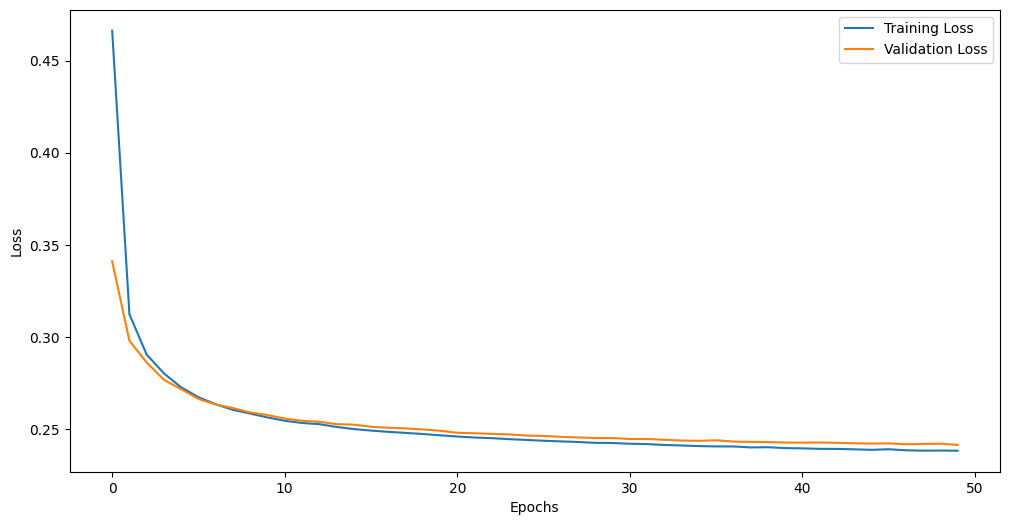

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(history_4.history['loss'], label = 'Training Loss')
plt.plot(history_4.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
final_image_4 = autoencoder_4.predict(x_test)

38/38 [==============================] - 1s 24ms/step


skor SSIM menaik menjadi 0.8637

In [ ]:
ssim_values_4 = []
for i in range(len(x_test)):
    ssim_value_4 = ssim(x_test[i].reshape(28, 28), final_image_4[i].reshape(28, 28), data_range_4 = final_image_4[i].max() - final_image_4[i].min())
    ssim_values_4.append(ssim_value_4)

mean_ssim_4 = np.mean(ssim_values_4)
print(f'Mean SSIM: {mean_ssim_4}')

Mean SSIM: 0.8637100873801222


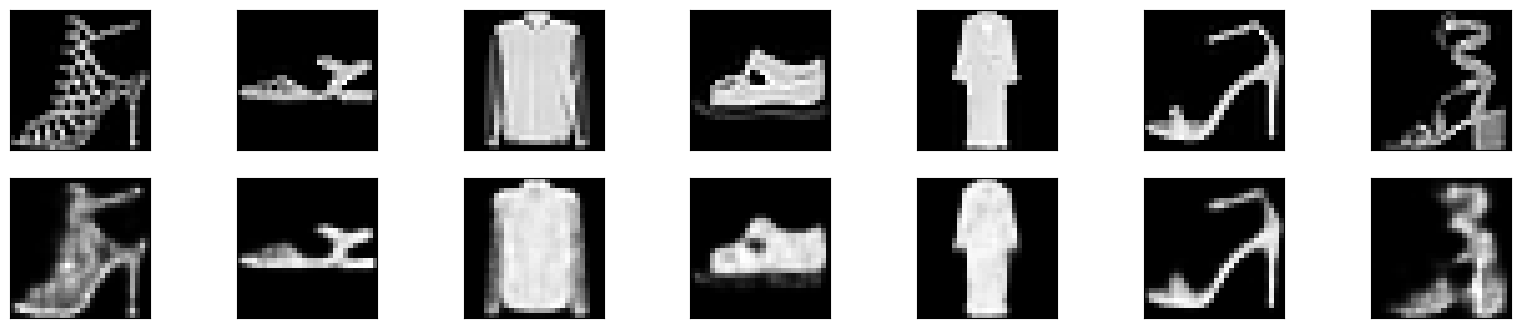

In [ ]:
plt.figure(figsize=(20, 4))
for i in range(7):
    # Display original
    ax = plt.subplot(2, 7, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, 7, i + 1 + 7)
    plt.imshow(final_image_4[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

mencoba 2 layer lagi dengan filternya yang lebih sedikit lagi 8 dan 16 dan menggunakan dropout agar tidak overfit

In [ ]:
#model tune 3
from keras.layers import Dropout
x2 = Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(input_image)
x2 = MaxPooling2D((2, 2), padding = 'same')(x2)
x2 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(x2)
x2 = MaxPooling2D((2, 2), padding = 'same')(x2)
x2 = Dropout(0.2)(x2)
x2 = Flatten()(x2)
encoded5 = Dense(64, activation = 'relu')(x2)

x2 = Dense(7 * 7 * 32, activation = 'relu')(encoded5)
x2 = Reshape((7, 7, 32))(x2)
x2 = UpSampling2D((2, 2))(x2)
x2 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(x2)
x2 = UpSampling2D((2, 2))(x2)
x2 = Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(x2)
x2 = Dropout(0.2)(x2)
decoded5 = Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(x2)

autoencoder_5 = Model(input_image, decoded5)
autoencoder_5.compile(optimizer = 'adam', loss = 'binary_crossentropy')
autoencoder_5.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 14, 14, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 14, 14, 16)        1168      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 7, 7, 16)          0         
 ng2D)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 16)          0   

train dengan batch size dan epoch yang sama

In [ ]:
history_5 = autoencoder_5.fit(x_train, x_train, epochs = 50, batch_size = 256, shuffle = True, validation_data = (x_val, x_val))

Epoch 1/50
38/38 [==============================] - 24s 555ms/step - loss: 0.4983 - val_loss: 0.3600
Epoch 2/50
38/38 [==============================] - 18s 468ms/step - loss: 0.3355 - val_loss: 0.3109
Epoch 3/50
38/38 [==============================] - 19s 485ms/step - loss: 0.3093 - val_loss: 0.2973
Epoch 4/50
38/38 [==============================] - 18s 473ms/step - loss: 0.2986 - val_loss: 0.2898
Epoch 5/50
38/38 [==============================] - 18s 471ms/step - loss: 0.2923 - val_loss: 0.2843
Epoch 6/50
38/38 [==============================] - 17s 458ms/step - loss: 0.2874 - val_loss: 0.2800
Epoch 7/50
38/38 [==============================] - 17s 454ms/step - loss: 0.2832 - val_loss: 0.2773
Epoch 8/50
38/38 [==============================] - 20s 522ms/step - loss: 0.2804 - val_loss: 0.2740
Epoch 9/50
38/38 [==============================] - 19s 494ms/step - loss: 0.2778 - val_loss: 0.2718
Epoch 10/50
38/38 [==============================] - 19s 490ms/step - loss: 0.2756 - val_lo

training loss dan validation loss lebih stabil lagi tetapi validation loss berada di bawah loss dimana ini menandakan underfit

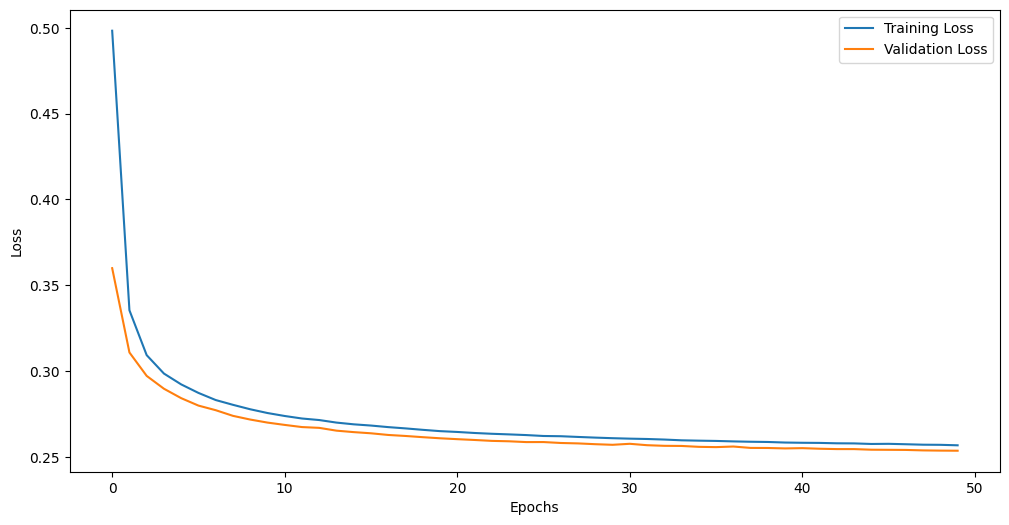

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(history_5.history['loss'], label = 'Training Loss')
plt.plot(history_5.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
final_image_5 = autoencoder_5.predict(x_test)

38/38 [==============================] - 1s 16ms/step


SSIM Skor menurun jauh menjadi 0.7849

In [ ]:
ssim_values_5 = []
for i in range(len(x_test)):
    ssim_value_5 = ssim(x_test[i].reshape(28, 28), final_image_5[i].reshape(28, 28), data_range_5 = final_image_5[i].max() - final_image_5[i].min())
    ssim_values_5.append(ssim_value_5)

mean_ssim_5 = np.mean(ssim_values_5)
print(f'Mean SSIM: {mean_ssim_5}')

Mean SSIM: 0.7849974515126309


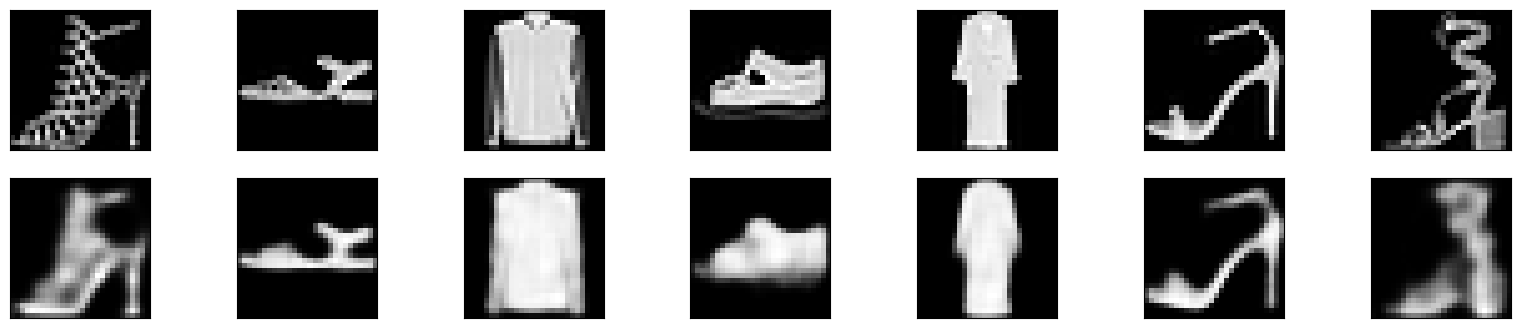

In [ ]:
plt.figure(figsize=(20, 4))
for i in range(7):
    # Display original
    ax = plt.subplot(2, 7, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, 7, i + 1 + 7)
    plt.imshow(final_image_5[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

mencoba menggunakan 1 layer dengan filter 8 (model lebih simple)

In [ ]:
#model tune 3
x3 = Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(input_image)
x3 = MaxPooling2D((2, 2), padding = 'same')(x3)
x3 = Flatten()(x3)
encoded6 = Dense(128, activation = 'relu')(x3)

x3 = Dense(14 * 14 * 32, activation = 'relu')(encoded6)
x3 = Reshape((14, 14, 32))(x3)
x3 = UpSampling2D((2, 2))(x3)
x3 = Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(x3)
decoded6 = Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(x3)

autoencoder_6 = Model(input_image, decoded6)
autoencoder_6.compile(optimizer = 'adam', loss = 'binary_crossentropy')
autoencoder_6.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 14, 14, 8)         0         
 ng2D)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 1568)              0         
                                                                 
 dense_14 (Dense)            (None, 128)               200832    
                                                                 
 dense_15 (Dense)            (None, 6272)              809088    
                                                           

train dengan epoch dan batch size sama

In [ ]:
history_6 = autoencoder_6.fit(x_train, x_train, epochs = 50, batch_size = 256, shuffle = True, validation_data = (x_val, x_val))

Epoch 1/50
38/38 [==============================] - 23s 573ms/step - loss: 0.4268 - val_loss: 0.3293
Epoch 2/50
38/38 [==============================] - 19s 492ms/step - loss: 0.3078 - val_loss: 0.2957
Epoch 3/50
38/38 [==============================] - 19s 489ms/step - loss: 0.2867 - val_loss: 0.2813
Epoch 4/50
38/38 [==============================] - 19s 492ms/step - loss: 0.2745 - val_loss: 0.2712
Epoch 5/50
38/38 [==============================] - 18s 478ms/step - loss: 0.2670 - val_loss: 0.2658
Epoch 6/50
38/38 [==============================] - 18s 469ms/step - loss: 0.2621 - val_loss: 0.2627
Epoch 7/50
38/38 [==============================] - 23s 598ms/step - loss: 0.2592 - val_loss: 0.2594
Epoch 8/50
38/38 [==============================] - 18s 474ms/step - loss: 0.2563 - val_loss: 0.2574
Epoch 9/50
38/38 [==============================] - 18s 485ms/step - loss: 0.2544 - val_loss: 0.2558
Epoch 10/50
38/38 [==============================] - 19s 505ms/step - loss: 0.2526 - val_lo

validation loss diatas training loss dan stabil menurun keduanya

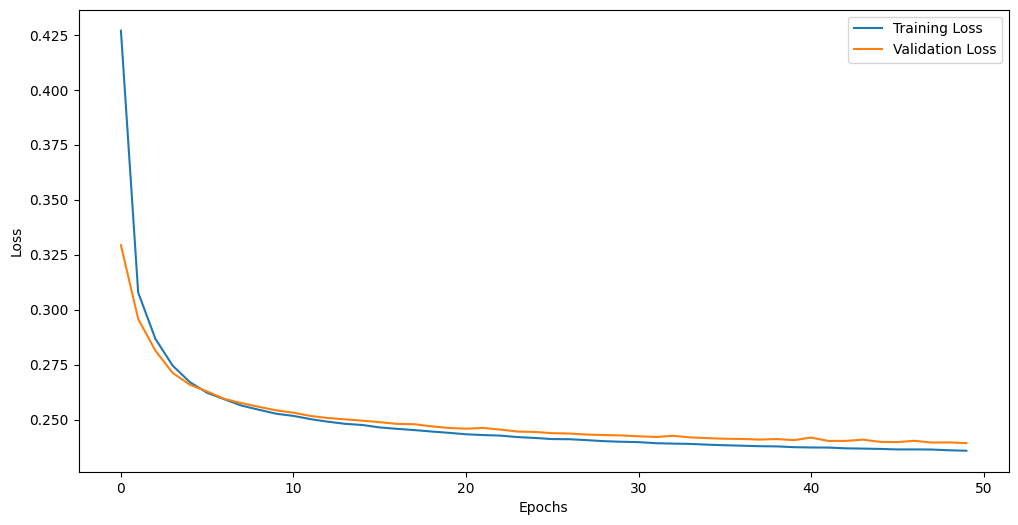

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(history_6.history['loss'], label = 'Training Loss')
plt.plot(history_6.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
final_image_6 = autoencoder_6.predict(x_test)

38/38 [==============================] - 1s 17ms/step


Skor SSIM naik lagi menjadi 0.8762

In [ ]:
ssim_values_6 = []
for i in range(len(x_test)):
    ssim_value_6 = ssim(x_test[i].reshape(28, 28), final_image_6[i].reshape(28, 28), data_range_6 = final_image_6[i].max() - final_image_6[i].min())
    ssim_values_6.append(ssim_value_6)

mean_ssim_6 = np.mean(ssim_values_6)
print(f'Mean SSIM: {mean_ssim_6}')

Mean SSIM: 0.8762658478476337


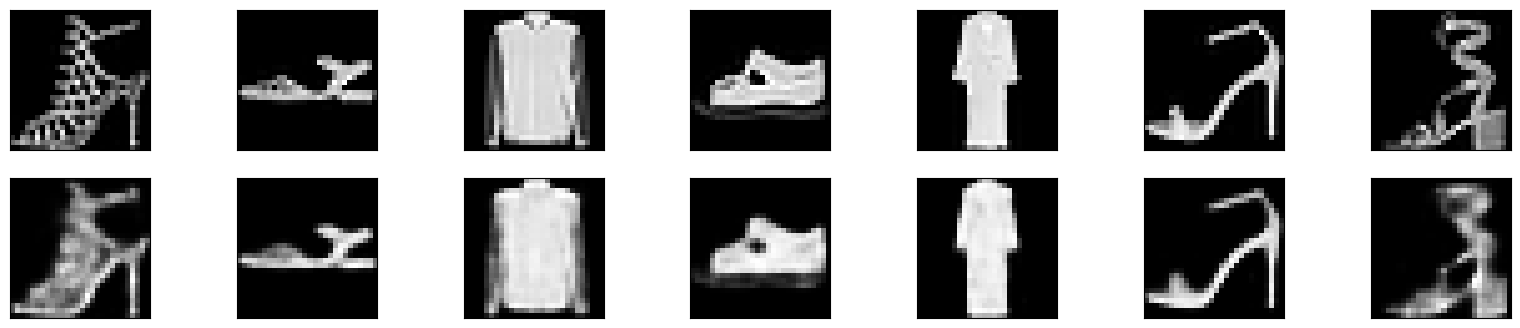

In [ ]:
plt.figure(figsize=(20, 4))
for i in range(7):
    # Display original
    ax = plt.subplot(2, 7, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, 7, i + 1 + 7)
    plt.imshow(final_image_6[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

mencoba dengan model yang sama 8 filter tetapi menaikkan unit di fully connected layer menjadi 256

In [ ]:
#model tune 3
x4 = Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(input_image)
x4 = MaxPooling2D((2, 2), padding = 'same')(x4)
x4 = Flatten()(x4)
encoded7 = Dense(256, activation = 'relu')(x4)

x4 = Dense(14 * 14 * 8, activation = 'relu')(encoded7)
x4 = Reshape((14, 14, 8))(x4)
x4 = UpSampling2D((2, 2))(x4)
x4 = Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(x4)
decoded7 = Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(x4)

autoencoder_7 = Model(input_image, decoded7)
autoencoder_7.compile(optimizer = 'adam', loss = 'binary_crossentropy')
autoencoder_7.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 8)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 1568)              0         
                                                                 
 dense_10 (Dense)            (None, 256)               401664    
                                                                 
 dense_11 (Dense)            (None, 1568)              402976    
                                                           

train dengan epoch dan batch size yang sama

In [ ]:
history_7 = autoencoder_7.fit(x_train, x_train, epochs = 50, batch_size = 256, shuffle = True, validation_data = (x_val, x_val))

Epoch 1/50
38/38 [==============================] - 17s 350ms/step - loss: 0.4603 - val_loss: 0.3470
Epoch 2/50
38/38 [==============================] - 15s 385ms/step - loss: 0.3209 - val_loss: 0.3036
Epoch 3/50
38/38 [==============================] - 18s 472ms/step - loss: 0.2929 - val_loss: 0.2860
Epoch 4/50
38/38 [==============================] - 13s 349ms/step - loss: 0.2788 - val_loss: 0.2752
Epoch 5/50
38/38 [==============================] - 12s 306ms/step - loss: 0.2697 - val_loss: 0.2678
Epoch 6/50
38/38 [==============================] - 12s 305ms/step - loss: 0.2639 - val_loss: 0.2635
Epoch 7/50
38/38 [==============================] - 12s 315ms/step - loss: 0.2601 - val_loss: 0.2603
Epoch 8/50
38/38 [==============================] - 10s 266ms/step - loss: 0.2572 - val_loss: 0.2577
Epoch 9/50
38/38 [==============================] - 12s 311ms/step - loss: 0.2551 - val_loss: 0.2563
Epoch 10/50
38/38 [==============================] - 11s 284ms/step - loss: 0.2533 - val_lo

training loss dan validation loss sama bagus

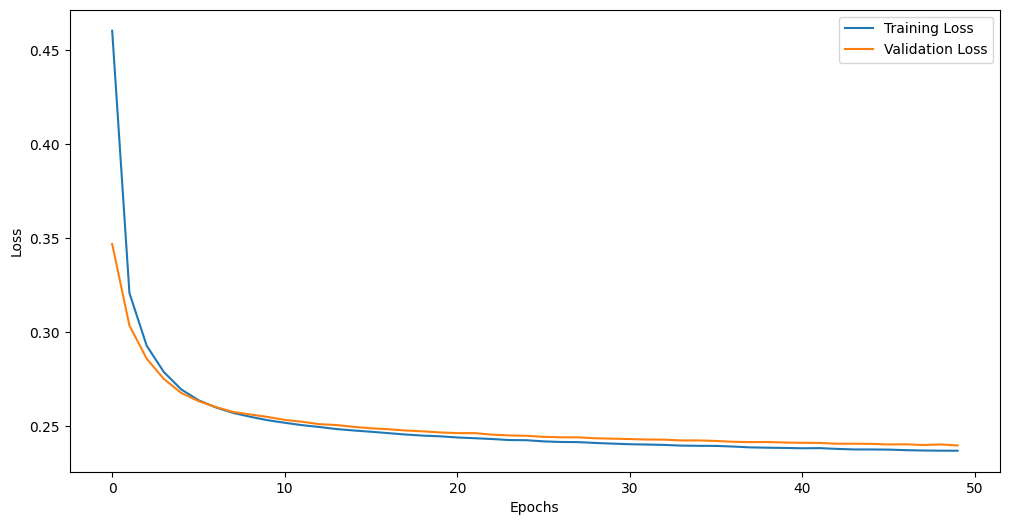

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(history_7.history['loss'], label = 'Training Loss')
plt.plot(history_7.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
ssim_values_train_7 = []
for i in range(len(x_train)):
    ssim_value_train_7 = ssim(x_train[i].reshape(28, 28), final_image_7[i].reshape(28, 28), data_range=final_image_train[i].max() - final_image_train[i].min())
    ssim_values_train_7.append(ssim_value_train)

mean_ssim_train = np.mean(ssim_values_train)
print(f'Mean SSIM for Training Data: {mean_ssim_train}')


In [ ]:
final_image_7 = autoencoder_7.predict(x_test)

38/38 [==============================] - 1s 12ms/step


Tetapi SSIM skor menurun menjadi 0.8689

In [ ]:
ssim_values_7 = []
for i in range(len(x_test)):
    ssim_value_7 = ssim(x_test[i].reshape(28, 28), final_image_7[i].reshape(28, 28), data_range_7 = final_image_7[i].max() - final_image_7[i].min())
    ssim_values_7.append(ssim_value_7)

mean_ssim_7 = np.mean(ssim_values_7)
print(f'Mean SSIM: {mean_ssim_7}')

Mean SSIM: 0.868994565229423


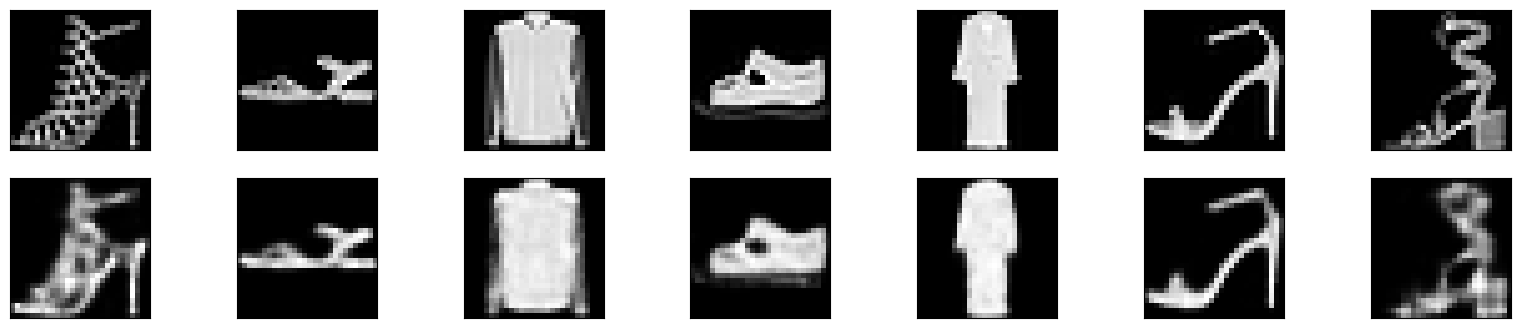

In [ ]:
plt.figure(figsize=(20, 4))
for i in range(7):
    # Display original
    ax = plt.subplot(2, 7, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, 7, i + 1 + 7)
    plt.imshow(final_image_7[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Kesimpulan: Model yang lebih simple memiliki hasil yang lebih baik. Hasil terbaik ada di skor 0.8762 dengan 1 layer menggunakan 8 filter. ini bisa terjadi kemungkinan data yang sedikit (hanya 2 kelas).

LINK VIDEO: https://binusianorg-my.sharepoint.com/personal/brandon_yang_binus_ac_id/_layouts/15/guestaccess.aspx?share=EWfAsy2q981NshWtuO0JZNkB1f0kOnSItfRLIYvNdydANw&nav=eyJyZWZlcnJhbEluZm8iOnsicmVmZXJyYWxBcHAiOiJPbmVEcml2ZUZvckJ1c2luZXNzIiwicmVmZXJyYWxBcHBQbGF0Zm9ybSI6IldlYiIsInJlZmVycmFsTW9kZSI6InZpZXciLCJyZWZlcnJhbFZpZXciOiJNeUZpbGVzTGlua0NvcHkifX0&e=R93pWF